In [1]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [2]:
def plot_all(fname, node_name):
    with open(os.path.abspath(fname)) as f:
        results = json.load(f)
    def extract_metrics(m):
        all_metrics = m[0]["all_metrics"]
        aggregated_metrics = {}
        for idx, trial in enumerate(all_metrics):
            data_lists = trial["data_lists"]
            for data in data_lists:
                for entry in data:
                    if idx == 0:
                        aggregated_metrics[entry] = {"times":[], "vals": []}
                    for item in data[entry]["items"]:
                        if len(item) == 1:
                            aggregated_metrics[entry]["times"].append(int(list(item.keys())[0]))
                            aggregated_metrics[entry]["vals"].append(float(list(item.values())[0]))
                        else:
                            for i in item:
                                aggregated_metrics[entry]["times"].append(int(list(i.keys())[0]))
                                aggregated_metrics[entry]["vals"].append(float(list(i.values())[0]))
    #     for m in aggregated_metrics:
    #         aggregated_metrics[m] = list(itertools.chain(aggregated_metrics[m]))
        return aggregated_metrics
    def plot_metrics():
        steady_metrics = extract_metrics(results["client_metrics"])
        init_metrics = extract_metrics(results["init_client_metrics"])
        for cur_metric in steady_metrics:
            fig, ax = plt.subplots(figsize=(16,8))
            if cur_metric == "{}:processing_latency".format(node_name):
                fig_cdf, ax_cdf = plt.subplots(figsize=(16,8))
            def plot(m, metrics, color, label):                
                init_time = metrics[m]["times"][0]
                times = np.array(metrics[m]["times"])
                offset_times = np.array(metrics[m]["times"]) - init_time
                vals = np.array(metrics[m]["vals"][10:])
                ax.scatter(offset_times[10:], vals, color=color, label=label)
                if m == "{}:processing_latency".format(node_name):
                    ax_cdf.hist(vals, 50, color=color, label=label, normed=1, histtype='step', cumulative=True,)
                    pred_thru = 1.0 / np.mean(vals) * 8 * 2 * 1000
                    print("{}: predicted thruput from mean proc latency: {}".format(label, pred_thru))
                    
                print("metric: {m}, stage: {label}, mean: {mean:.4f}, std: {std:.4f}".format(
                    m=m,
                    label=label,
                    mean=np.mean(vals),
                    std=np.std(vals),
                ))
            plot(cur_metric, steady_metrics, "blue", "steady")
            plot(cur_metric, init_metrics, "orange", "init")
            print("")
            if "queue_sizes" in cur_metric:
                ax.set_yscale("log")
            ax.set_xlabel("time offset (us)")
            ax.legend()
            ax.set_title(cur_metric)
            ax_cdf.legend()
            ax_cdf.set_title(cur_metric)
        plt.show()

    plot_metrics()

    def extract_batch_sizes(m):
        all_metrics = m[0]["all_metrics"]
        batch_sizes = {"min": [], "mean": [], "p50": []}
        for idx, trial in enumerate(all_metrics):
            hists = trial["histograms"]
            for h in hists:
                name = list(h.keys())[0]
                vals = list(h.values())[0]
                if "batch_size" in name:
                    for v in vals:
                        if v in batch_sizes:
                            batch_sizes[v].append(float(vals[v]))
        return batch_sizes

    def plot_batch_sizes():
        steady_batches = extract_batch_sizes(results["client_metrics"])
        init_batches = extract_batch_sizes(results["init_client_metrics"])
        for m in steady_batches:
            fig, ax = plt.subplots(figsize=(12,8))
            ax.scatter(np.arange(len(steady_batches[m])) + 0.25, steady_batches[m], color="blue", label="steady")
            ax.scatter(np.arange(len(init_batches[m])) - 0.25, init_batches[m], color="orange", label="init")
            ax.set_title("{} batch size".format(m))
            ax.legend()
            ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.4)
        plt.show()

    plot_batch_sizes()

    def plot_thruputs():
        steady_thrus = results["client_metrics"][0]["thrus"]
        init_thrus = results["init_client_metrics"][0]["thrus"] 
        fig, ax = plt.subplots(figsize=(12,8))
        ax.plot(np.arange(len(steady_thrus)) + 0.25, steady_thrus, color="blue", label="steady")
        ax.plot(np.arange(len(init_thrus)) - 0.25, init_thrus, color="orange", label="init")
        ax.set_title("Mean Throughput")
        ax.legend()
        ax.set_ylim(bottom=0)
        plt.show()
        print("init mean throughput: {}, std: {}".format(np.mean(init_thrus), np.std(init_thrus)))
        print("steady mean throughput: {}, std: {}".format(np.mean(steady_thrus), np.std(steady_thrus)))

    plot_thruputs()
    
    def plot_container_metrics():
            loop_durs = np.array(results["container_metrics"]["loop_durs"][10:]) / 1000.0
            handle_durs = np.array(results["container_metrics"]["handle_durs"][10:]) / 1000.0

            fig, ax = plt.subplots(figsize=(12,8))
    #         ax.scatter(np.arange(len(loop_durs)), loop_durs, color="green", label="loop durs")
            ax.scatter(np.arange(len(handle_durs)), handle_durs, color="green", label="handle durs")
            ax.set_title("Container metrics")
            ax.set_ylabel("duration (ms)")
            ax.legend()
            ax.set_ylim(bottom=0)
            plt.show()

    if "container_metrics" in results:
        plot_container_metrics()

In [11]:
init_vs_steady_fname = "results/profiler_debugging/pytorch_res50_smp_gcp_init_stats_and_steady_stats_no_convergence_check/results-p100-2-8-180220_215327.json"
# plot_all(init_vs_steady_fname, "res50")

## PyTorch Res50: Batch 8, Repeated Init

steady: predicted thruput from mean proc latency: 185.9167423792593
metric: res50:processing_latency, stage: steady, mean: 86.0600, std: 11.4772
init: predicted thruput from mean proc latency: 180.60052314575407
metric: res50:processing_latency, stage: init, mean: 88.5933, std: 10.0760

metric: model:res50:1:prediction_latencies_list, stage: steady, mean: 88441.2820, std: 11169.6264
metric: model:res50:1:prediction_latencies_list, stage: init, mean: 90226.8836, std: 9817.6361

metric: res50:1:queue_arrivals, stage: steady, mean: 2374840414.3538, std: 265829610.7646
metric: res50:1:queue_arrivals, stage: init, mean: 1413202815.4472, std: 262741335.9380

metric: res50:1:queue_sizes, stage: steady, mean: 291519.3023, std: 168497.6034
metric: res50:1:queue_sizes, stage: init, mean: 288902.1610, std: 167032.0357

metric: app:res50:prediction_latencies, stage: steady, mean: 363939313.8517, std: 208082977.7740
metric: app:res50:prediction_latencies, stage: init, mean: 356296481.4532, std: 204

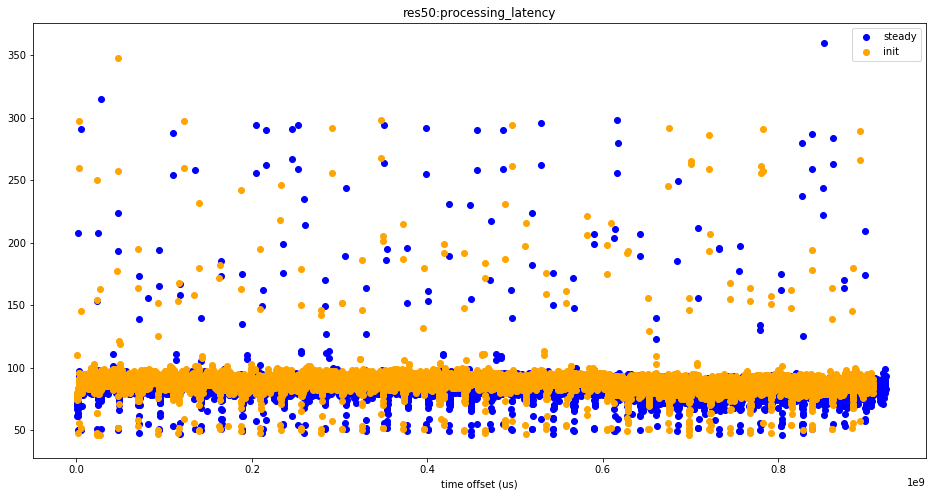

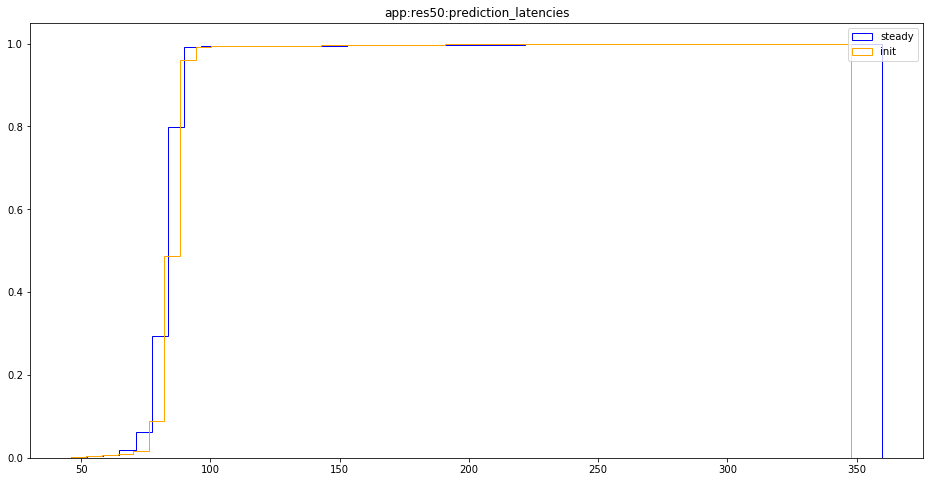

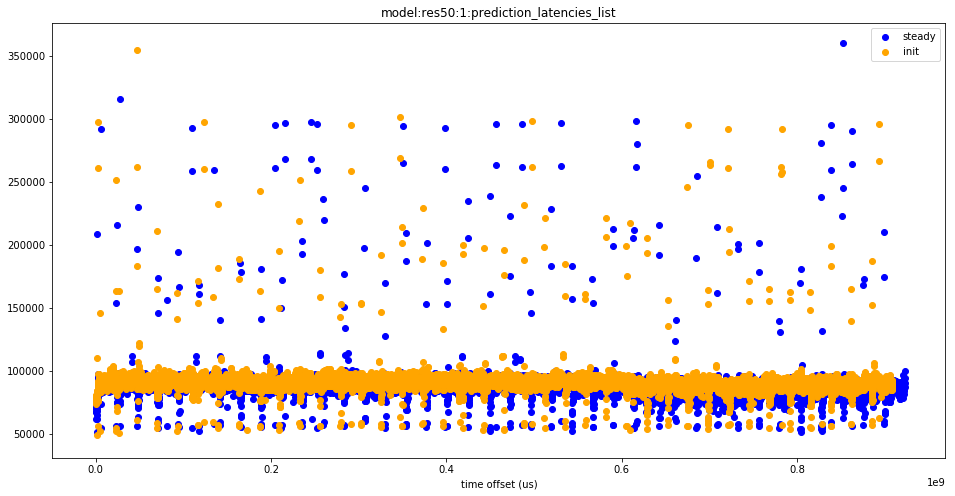

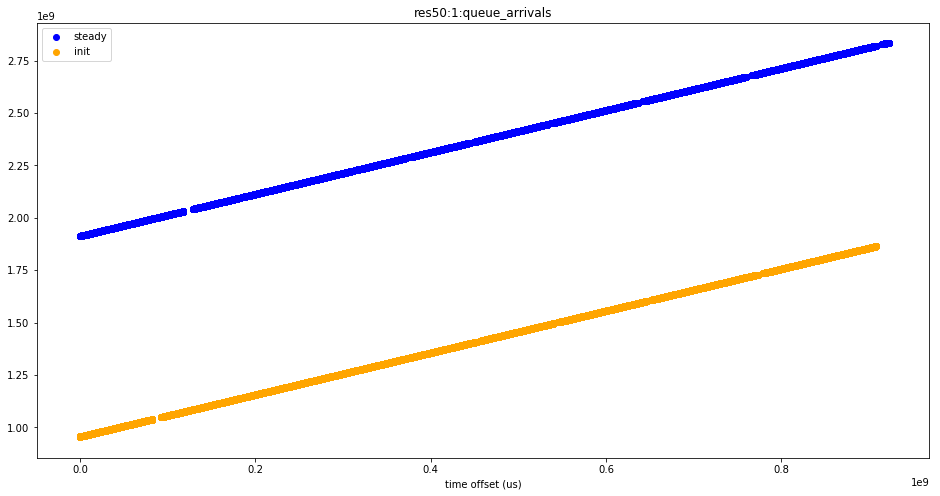

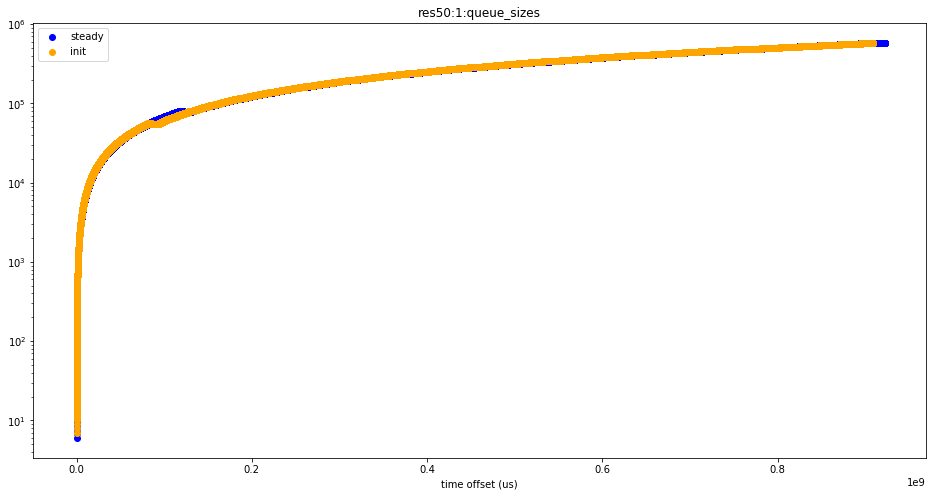

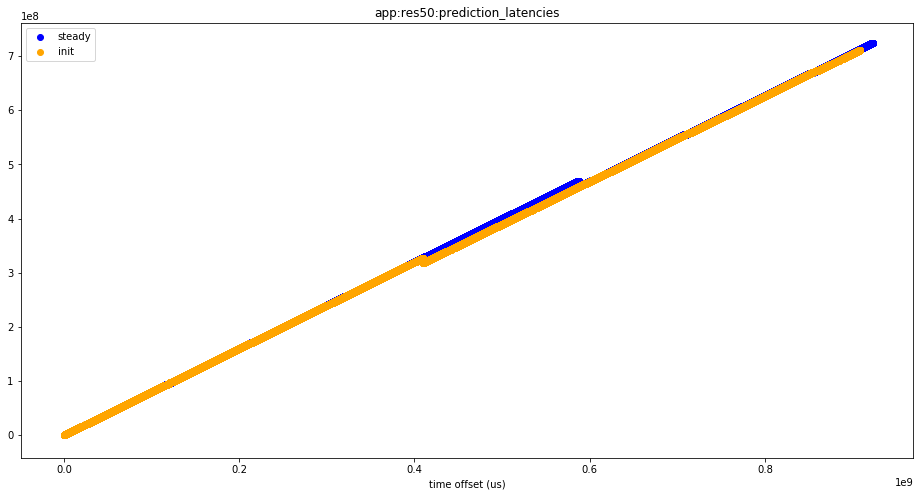

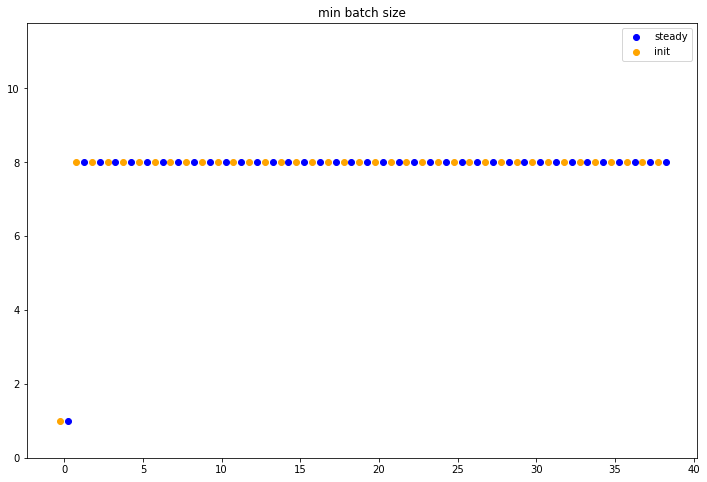

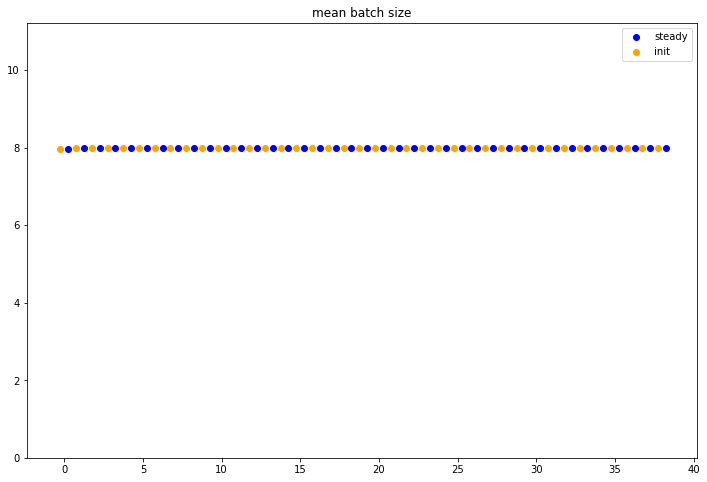

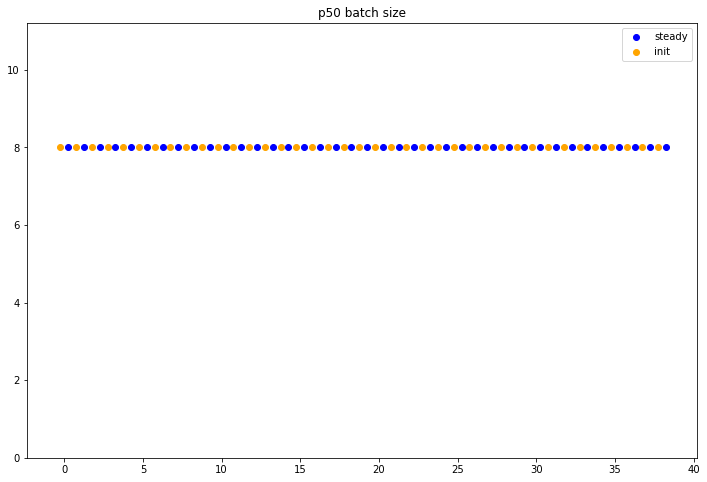

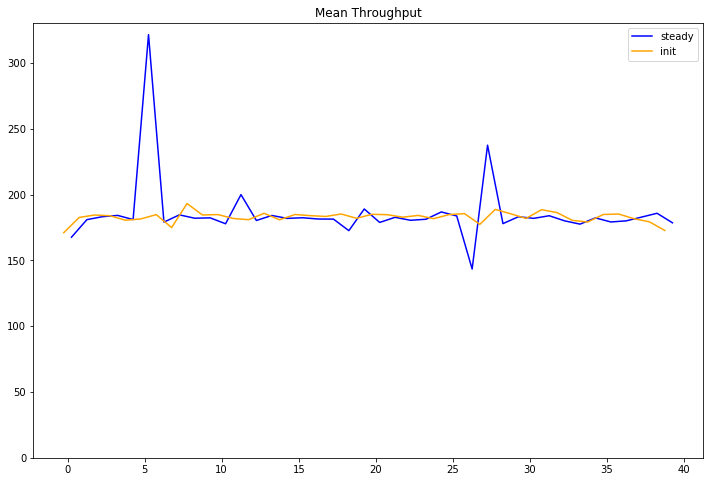

init mean throughput: 182.8925840351115, std: 4.01061410605808
steady mean throughput: 185.64269999378797, std: 24.673379689957738


In [4]:
repeat_init_fname = "results/profiler_debugging/pytorch_res50_smp_gcp_repeat_init_stats/results-p100-2-8-repeat-init-180220_213335.json"
plot_all(repeat_init_fname, "res50")

## PyTorch Res50: Batch 8, Init vs steady

steady: predicted thruput from mean proc latency: 156.18401134885872
metric: res50:processing_latency, stage: steady, mean: 102.4433, std: 13.0264
init: predicted thruput from mean proc latency: 153.71118431817868
metric: res50:processing_latency, stage: init, mean: 104.0913, std: 10.9668

metric: model:res50:1:prediction_latencies_list, stage: steady, mean: 103104.8189, std: 13055.0725
metric: model:res50:1:prediction_latencies_list, stage: init, mean: 105182.8289, std: 10870.5180

metric: res50:1:queue_arrivals, stage: steady, mean: 2689527830.7325, std: 304027931.3060
metric: res50:1:queue_arrivals, stage: init, mean: 1596389094.8921, std: 298740249.1766

metric: res50:1:queue_sizes, stage: steady, mean: 2596.4683, std: 919.6022
metric: res50:1:queue_sizes, stage: init, mean: 342938.6115, std: 199144.7017

metric: app:res50:prediction_latencies, stage: steady, mean: 17247999.3117, std: 5989749.9145
metric: app:res50:prediction_latencies, stage: init, mean: 416493368.3473, std: 24660

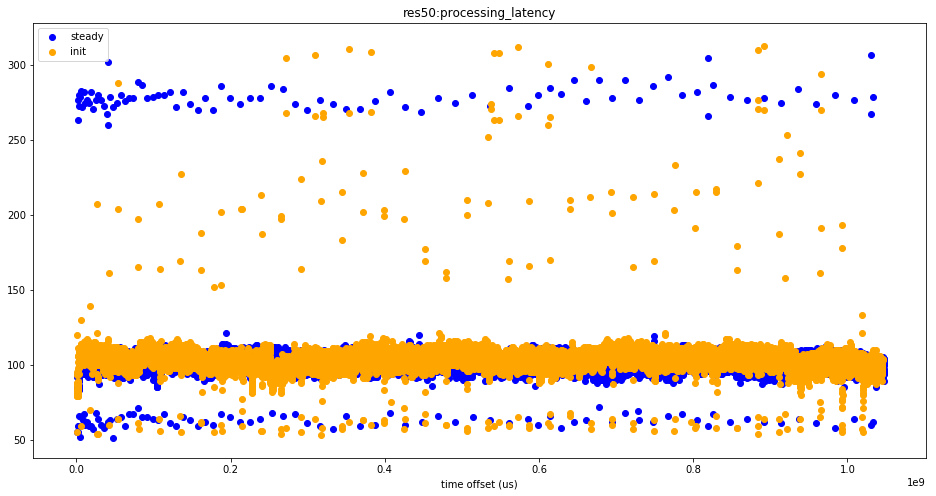

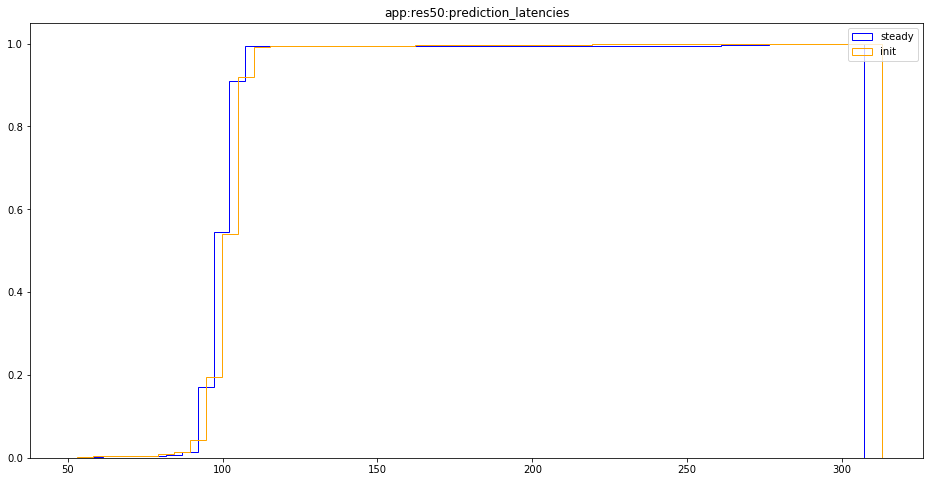

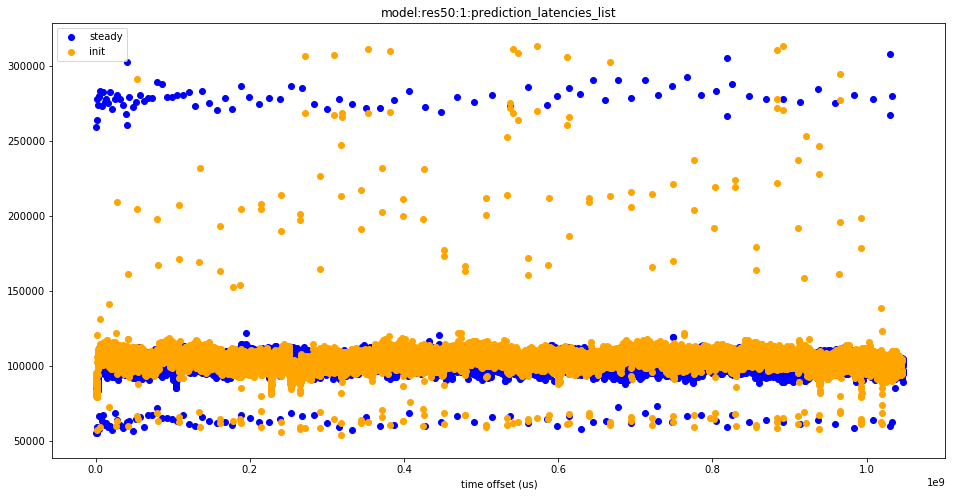

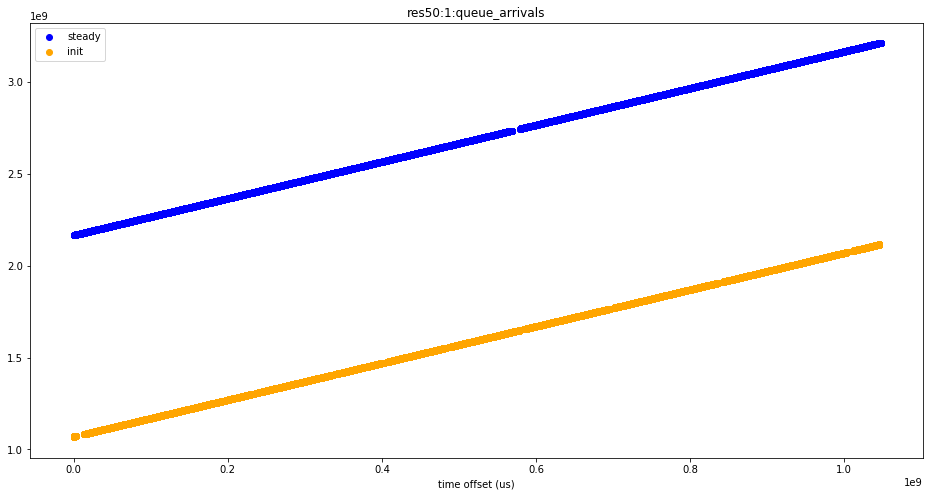

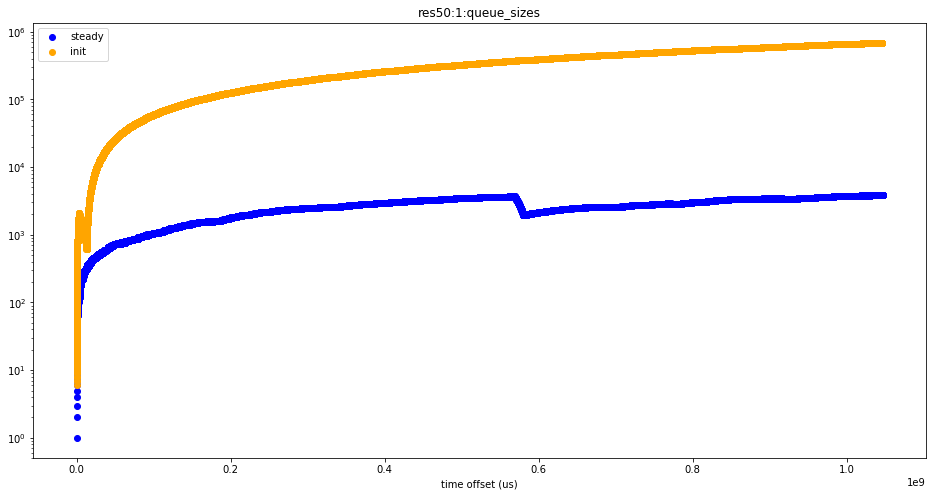

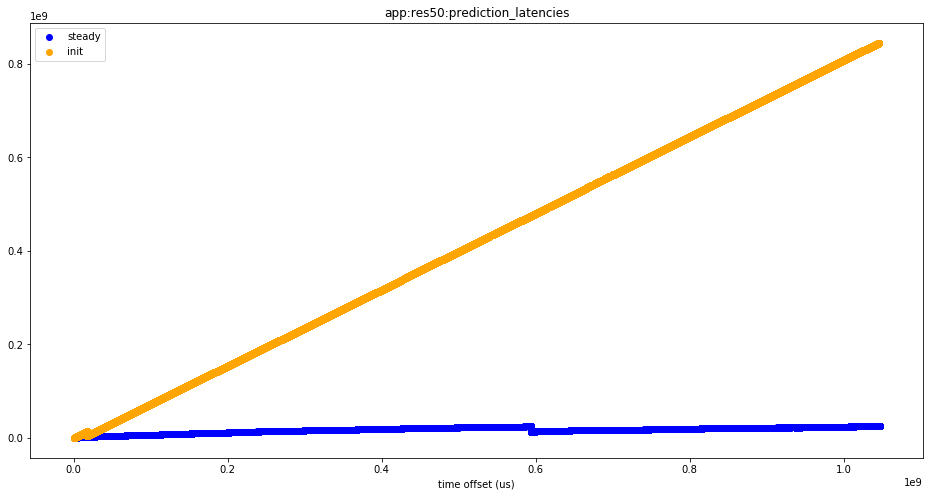

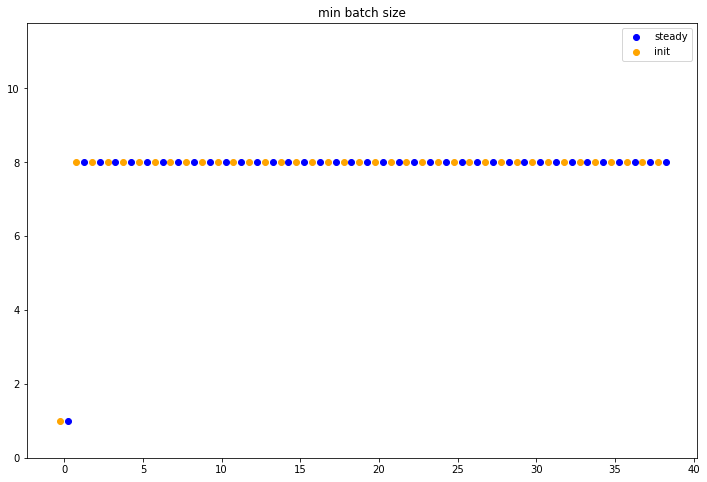

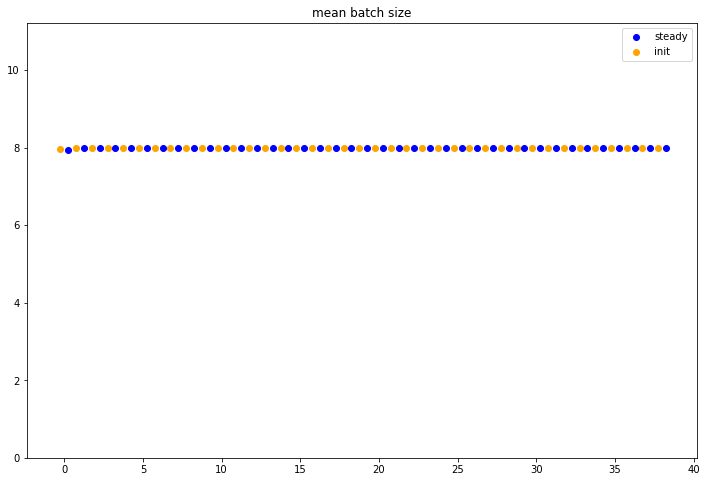

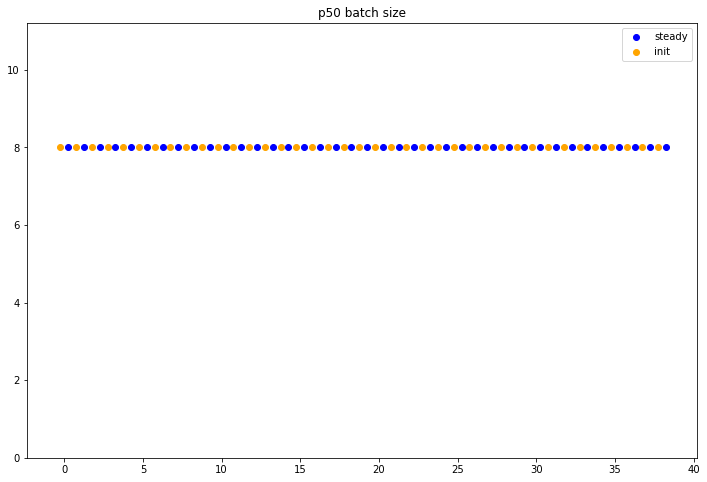

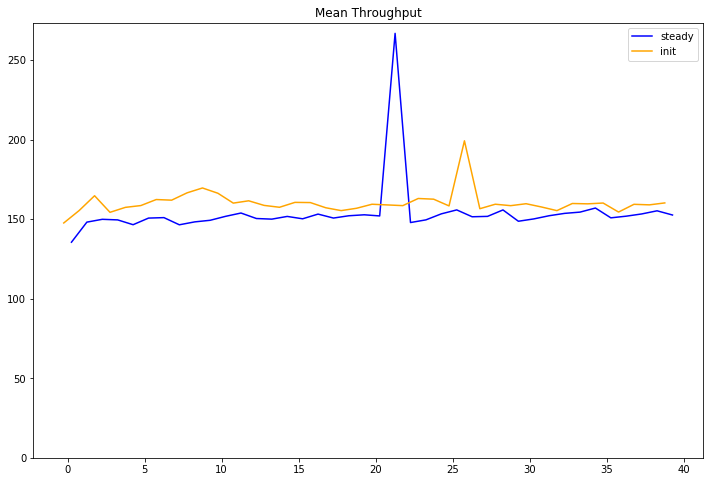

init mean throughput: 160.25840345221286, std: 7.251611498658028
steady mean throughput: 153.85712191332937, std: 18.39495924900281


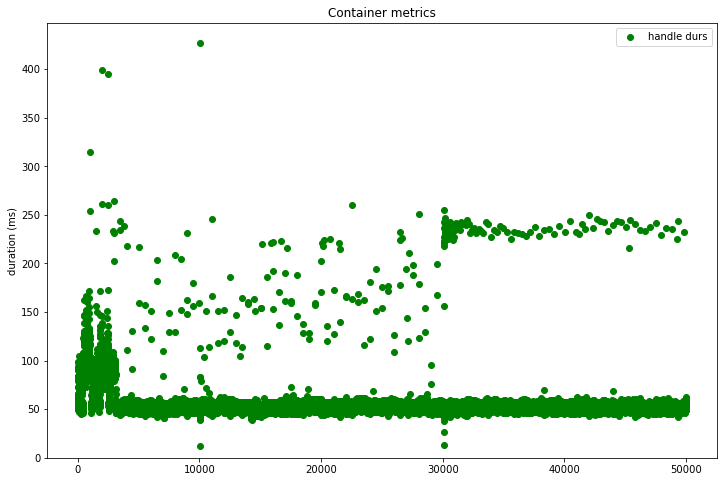

In [5]:
container_logs_fname = "results/profiler_debugging/pytorch_res50_smp_gcp_init_stats_and_steady_stats_no_convergence_check//results-p100-2-8-with-container-logs-180221_022748.json"
plot_all(container_logs_fname, "res50")


## PyTorch Res50: Batch 8, Init vs steady

In [ ]:
container_logs_fname = "results/profiler_debugging/pytorch_res50_smp_gcp_init_stats_and_steady_stats_no_convergence_check//results-p100-2-8-with-container-logs-180221_022748.json"
fname = container_logs_fname
with open(os.path.abspath(fname)) as f:
        results = json.load(f)
def plot_container_metrics():
        loop_durs = np.array(results["container_metrics"]["loop_durs"][10:]) / 1000.0
        handle_durs = np.array(results["container_metrics"]["handle_durs"][10:]) / 1000.0

        fig, ax = plt.subplots(figsize=(12,8))
#         ax.scatter(np.arange(len(loop_durs)), loop_durs, color="green", label="loop durs")
        ax.scatter(np.arange(len(handle_durs)), handle_durs, color="green", label="handle durs")
        ax.set_title("Container metrics")
        ax.set_ylabel("duration (ms)")
        ax.legend()
        ax.set_ylim(bottom=0)
        plt.show()

plot_container_metrics()

steady: predicted thruput from mean proc latency: 81.75113722456919
metric: tf-resnet-feats:processing_latency, stage: steady, mean: 195.7159, std: 18.6571
init: predicted thruput from mean proc latency: 80.82137539108466
metric: tf-resnet-feats:processing_latency, stage: init, mean: 197.9674, std: 15.8995

metric: model:tf-resnet-feats:1:prediction_latencies_list, stage: steady, mean: 196378.2843, std: 18684.0559
metric: model:tf-resnet-feats:1:prediction_latencies_list, stage: init, mean: 198898.9212, std: 15810.7766

metric: tf-resnet-feats:1:queue_arrivals, stage: steady, mean: 3197259707.2450, std: 424357192.3649
metric: tf-resnet-feats:1:queue_arrivals, stage: init, mean: 1657100906.4611, std: 421754638.9633

metric: tf-resnet-feats:1:queue_sizes, stage: steady, mean: 2209.1394, std: 895.9939
metric: tf-resnet-feats:1:queue_sizes, stage: init, mean: 529789.6227, std: 305897.9726

metric: app:tf-resnet-feats:prediction_latencies, stage: steady, mean: 27714939.2559, std: 11225702.9

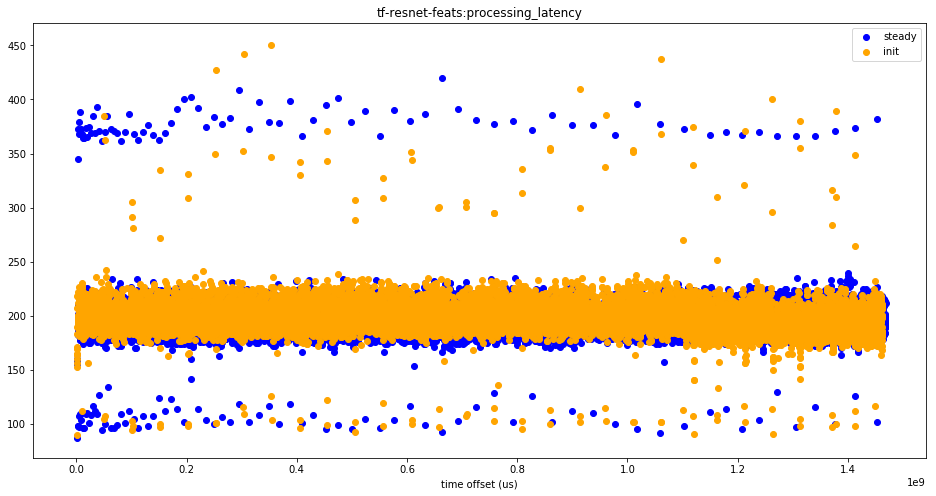

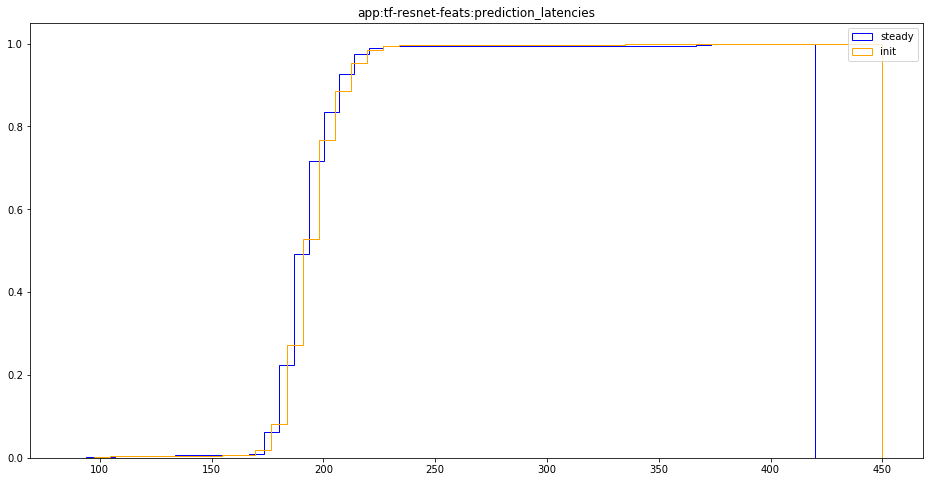

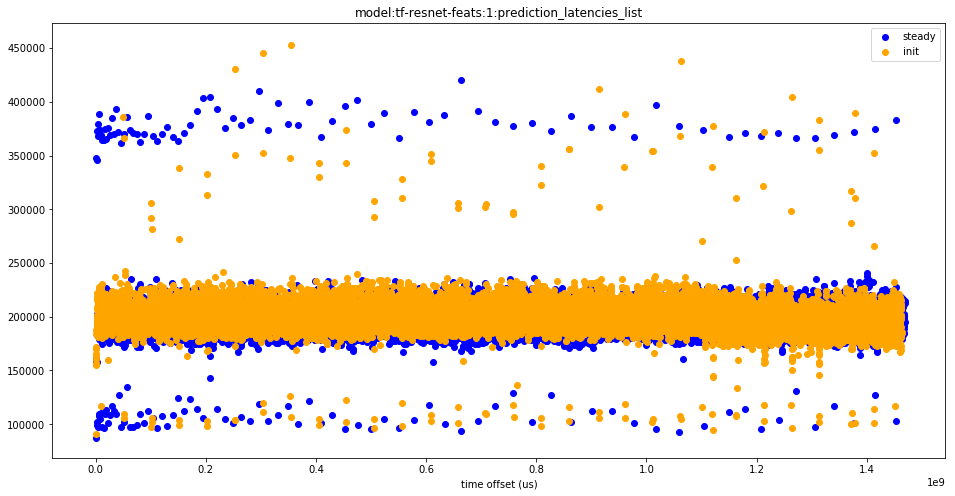

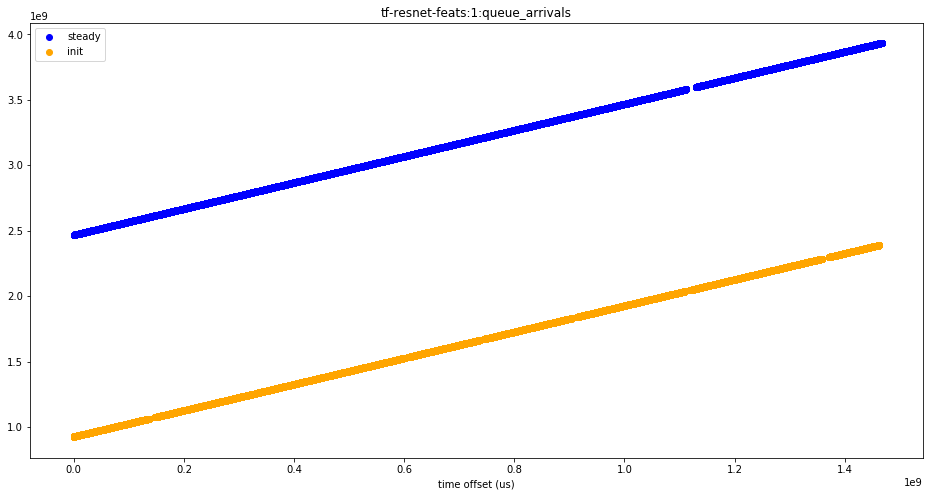

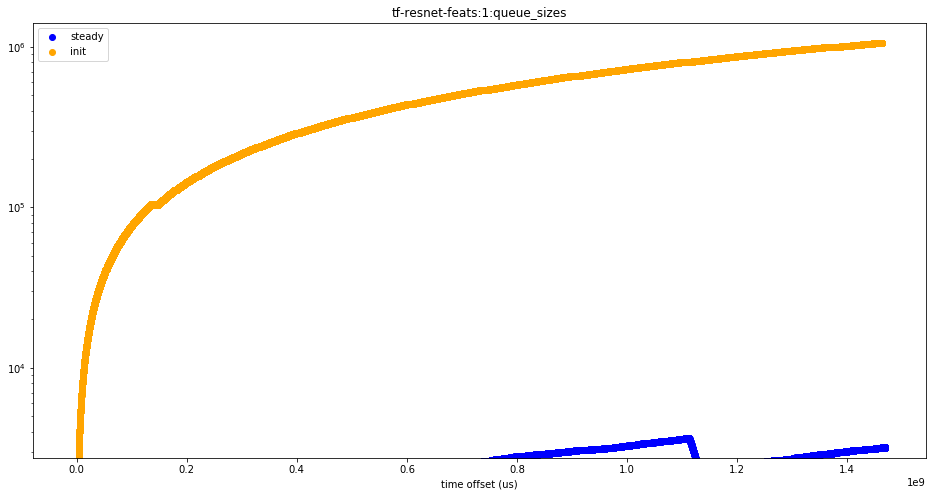

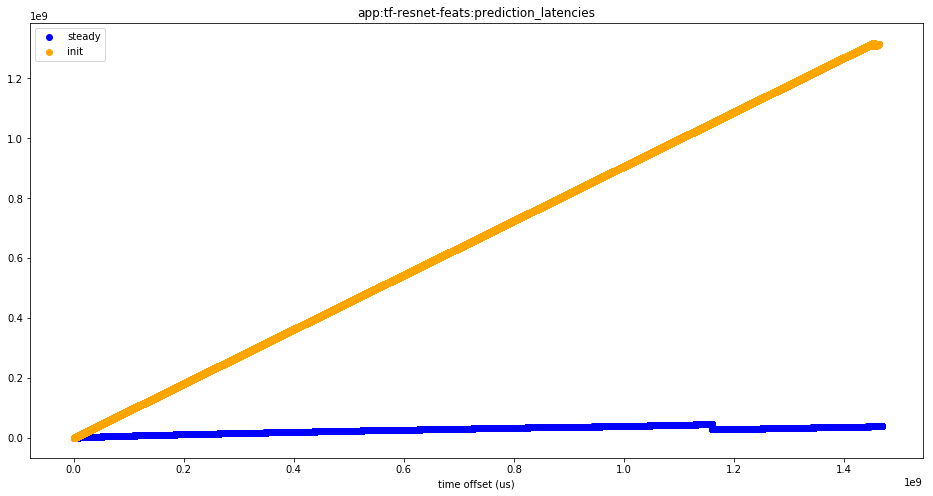

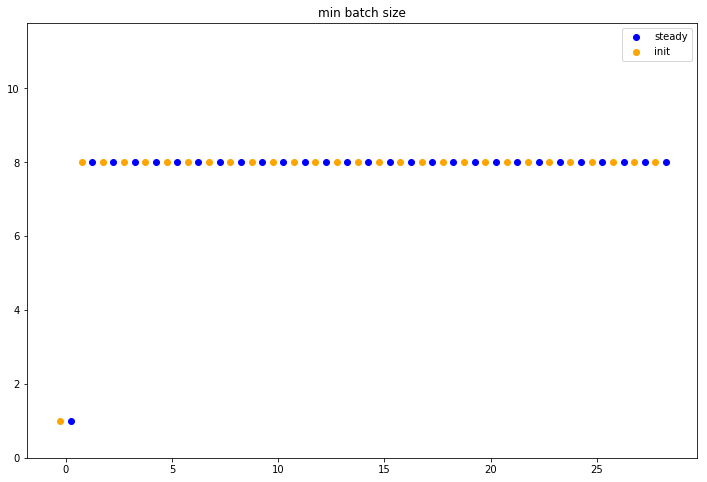

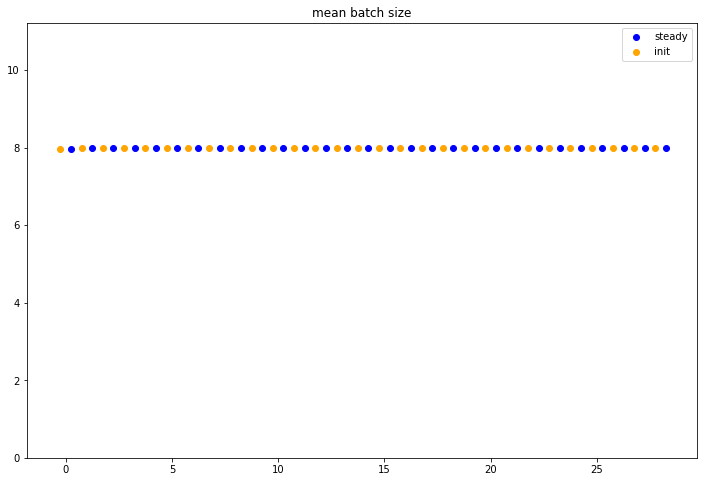

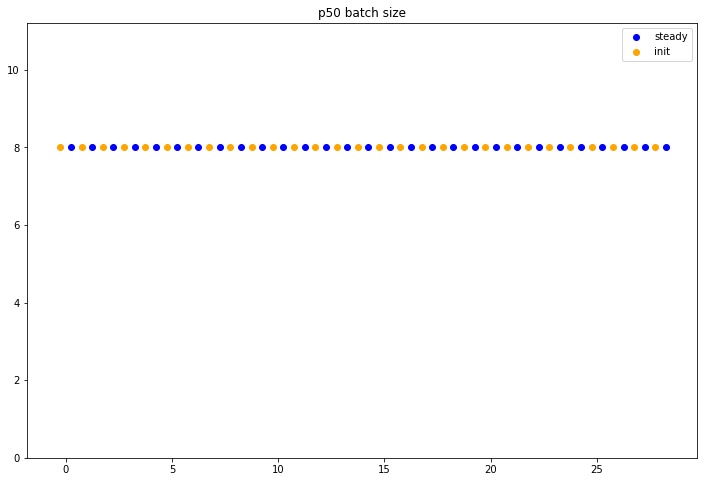

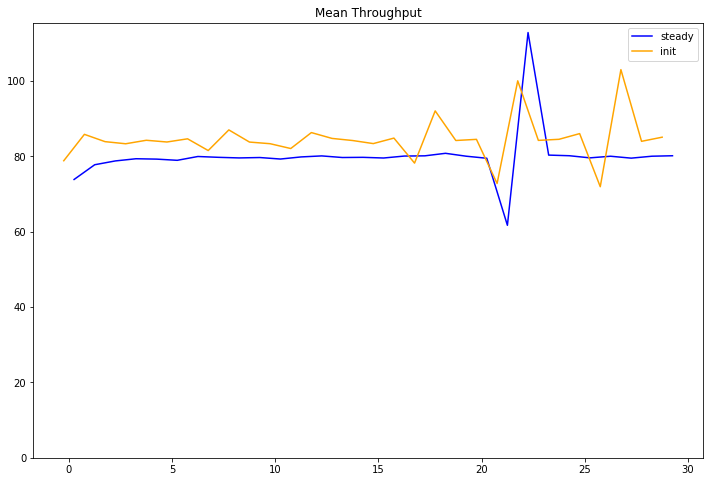

init mean throughput: 84.59486155200747, std: 5.897983011098496
steady mean throughput: 80.04545054580265, std: 6.98662850547609


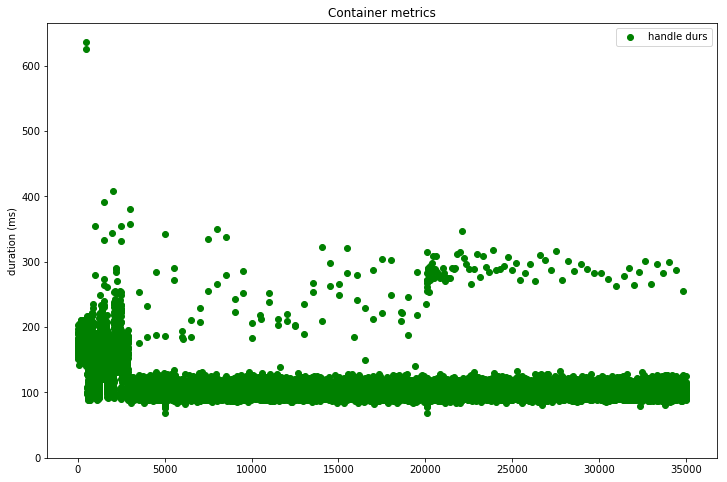

In [9]:
tf_container_logs_fname = "results/profiler_debugging/tf_resnet_smp_gcp_init_stats_and_steady_stats_no_convergence_check/results-p100-2-8-with-container-logs-180221_222655.json"
plot_all(tf_container_logs_fname, "tf-resnet-feats")


steady: predicted thruput from mean proc latency: 61.02387496972187
metric: tf-resnet-feats:processing_latency, stage: steady, mean: 262.1925, std: 20.5246
init: predicted thruput from mean proc latency: 61.101162415444875
metric: tf-resnet-feats:processing_latency, stage: init, mean: 261.8608, std: 14.8441

metric: model:tf-resnet-feats:1:prediction_latencies_list, stage: steady, mean: 262923.5295, std: 20392.1078
metric: model:tf-resnet-feats:1:prediction_latencies_list, stage: init, mean: 262614.6047, std: 14622.5902

metric: tf-resnet-feats:1:queue_arrivals, stage: steady, mean: 2235342108.1841, std: 280349889.5166
metric: tf-resnet-feats:1:queue_arrivals, stage: init, mean: 1218297997.9982, std: 275539098.7064

metric: tf-resnet-feats:1:queue_sizes, stage: steady, mean: 1564.9099, std: 615.7853
metric: tf-resnet-feats:1:queue_sizes, stage: init, mean: 327362.3971, std: 189433.8872

metric: app:tf-resnet-feats:prediction_latencies, stage: steady, mean: 13205869.4491, std: 7958838.0

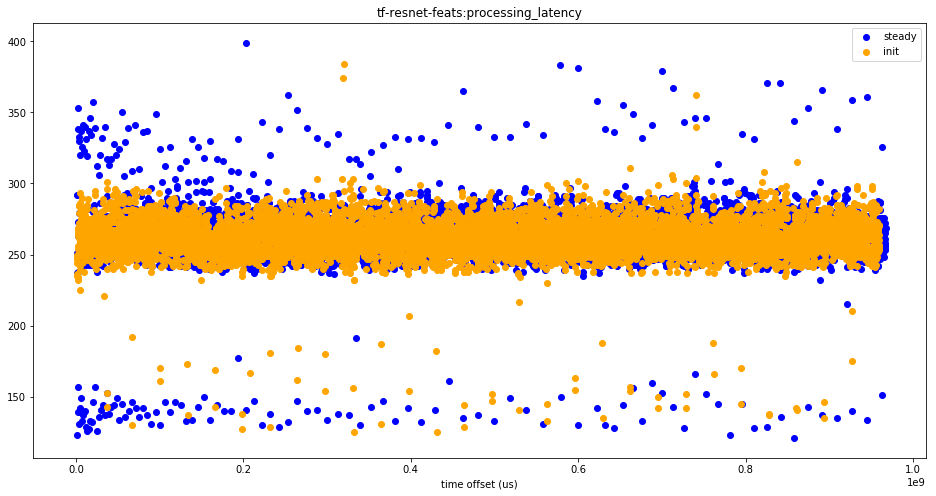

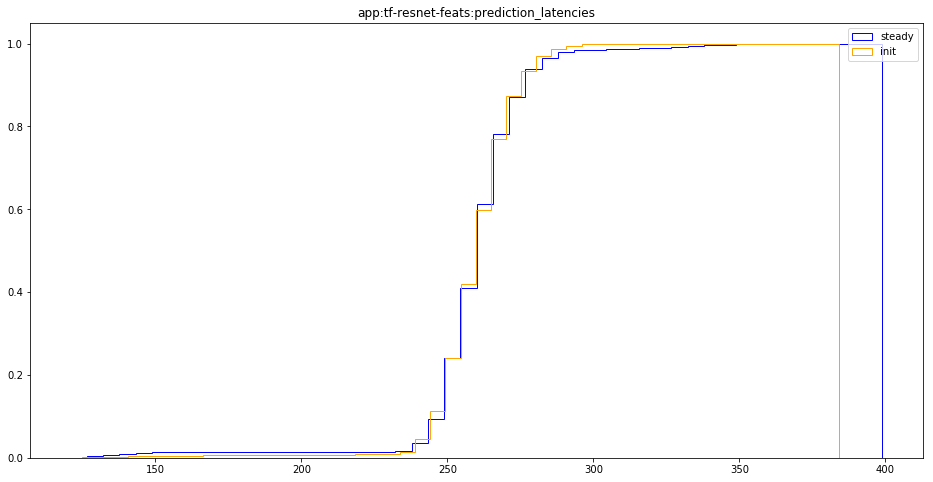

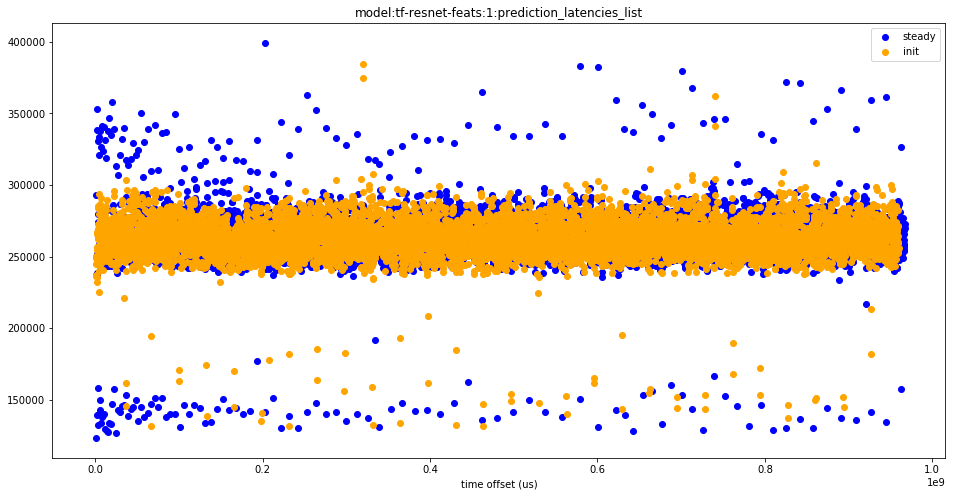

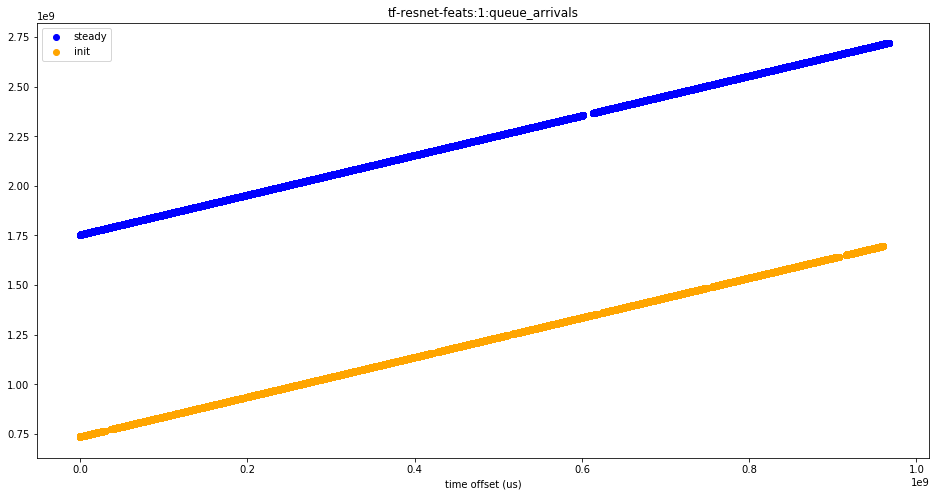

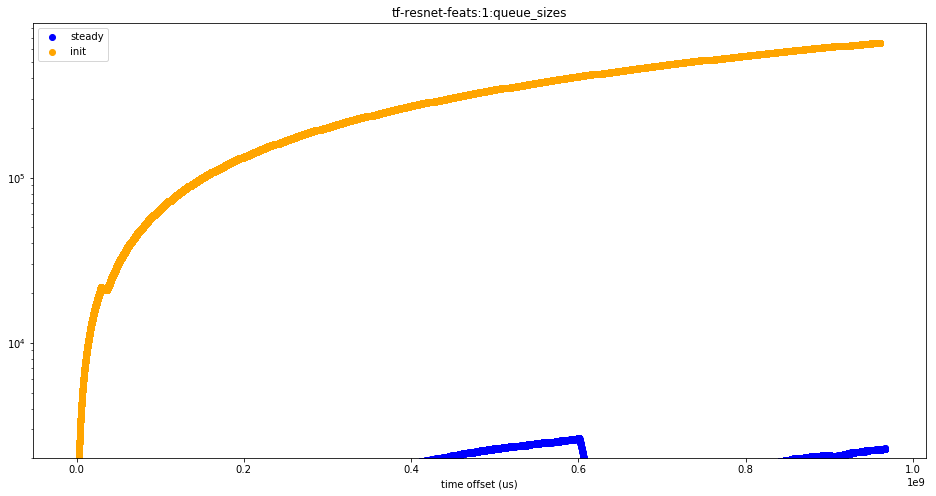

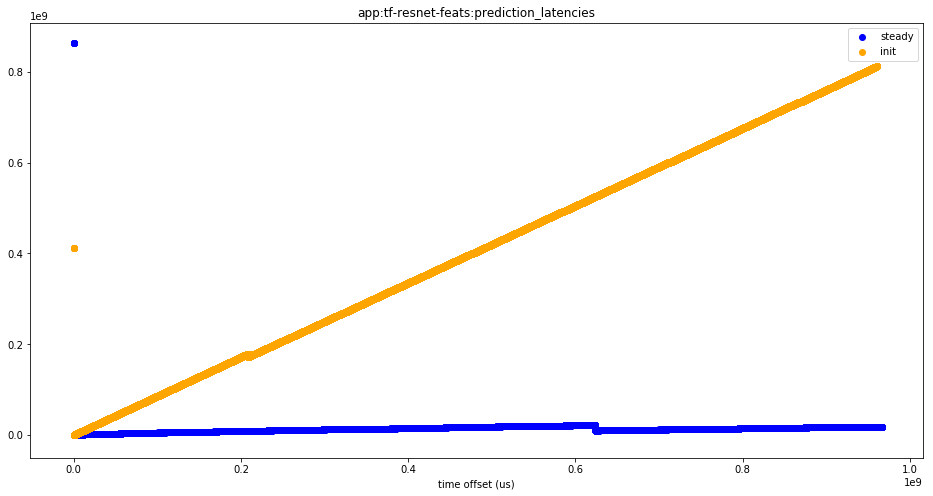

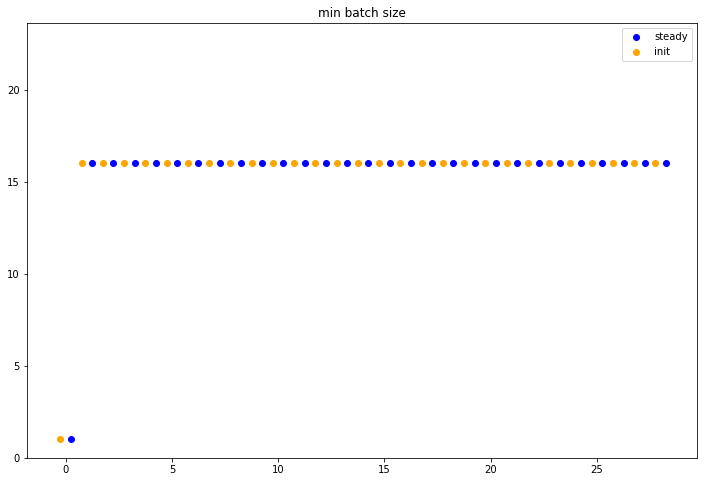

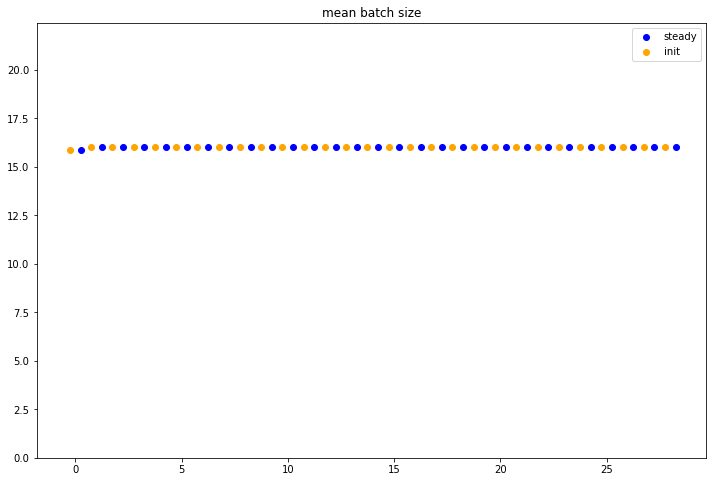

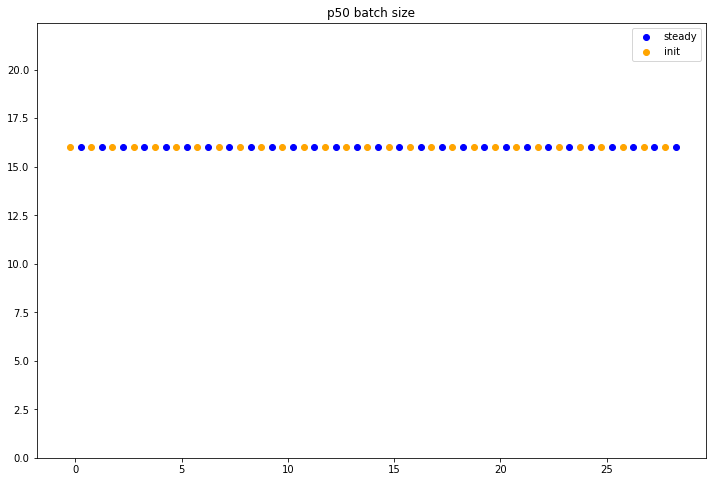

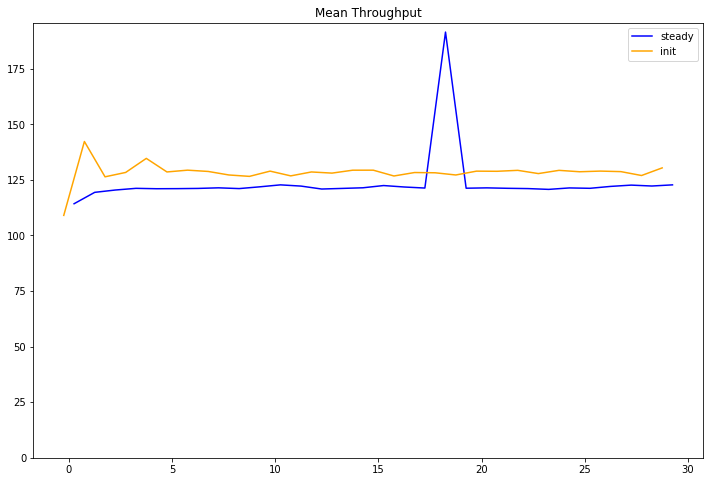

init mean throughput: 128.32621444293656, std: 4.597916094039249
steady mean throughput: 123.52093744342298, std: 12.69609132653316


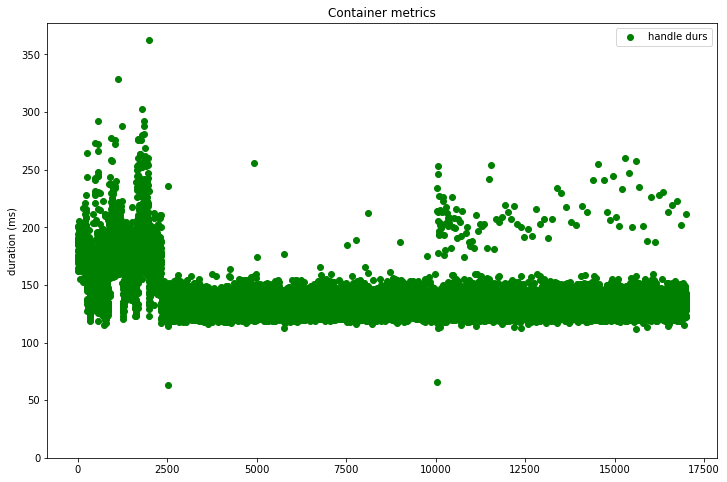

In [10]:
tf_container_logs_fname_batch_16 = "results/profiler_debugging/tf_resnet_smp_gcp_init_stats_and_steady_stats_no_convergence_check/results-p100-2-16-with-container-logs-180221_231810.json"
plot_all(tf_container_logs_fname_batch_16, "tf-resnet-feats")